In [8]:
import pandas as pd
import osmnx as ox
import numpy as np
from networkx import NetworkXNoPath
from tqdm import tqdm

# Normalizing Citi bike data

The goal here is to load all of the Citi bike trip info and normalize it, joining it to the same rough data structure as we have for the crash data and then have a row for each node that each trip passed through.

First, let's load all of the data from 2019, the last full "normal" year:

In [2]:
from pathlib import Path
from zipfile import ZipFile

trip_df = pd.DataFrame()
data_path = Path('../../data/citibike/')
for zipfile in data_path.glob('2019*.csv.zip'):
    with ZipFile(data_path / zipfile) as zf:
        for file in zf.infolist():
            if file.filename.endswith('.csv') and not file.filename.startswith('__'):
                print(file.filename)
                trip_df = pd.concat((trip_df, pd.read_csv(zf.open(file.filename))))
            
trip_df

201910-citibike-tripdata.csv
201905-citibike-tripdata.csv
201902-citibike-tripdata.csv
201912-citibike-tripdata.csv
201907-citibike-tripdata.csv
201908-citibike-tripdata.csv
201901-citibike-tripdata.csv
201909-citibike-tripdata.csv
201906-citibike-tripdata.csv
201903-citibike-tripdata.csv
201904-citibike-tripdata.csv
201911-citibike-tripdata.csv


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,527,2019-10-01 00:00:05.6180,2019-10-01 00:08:52.9430,3746.0,6 Ave & Broome St,40.724308,-74.004730,223.0,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1
1,174,2019-10-01 00:00:15.8750,2019-10-01 00:03:10.1680,3301.0,Columbus Ave & W 95 St,40.791956,-73.968087,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,18264,Subscriber,1992,1
2,759,2019-10-01 00:00:19.8240,2019-10-01 00:12:59.7070,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,174.0,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1
3,615,2019-10-01 00:00:21.0680,2019-10-01 00:10:36.6790,254.0,W 11 St & 6 Ave,40.735324,-73.998004,477.0,W 41 St & 8 Ave,40.756405,-73.990026,30186,Subscriber,1992,1
4,761,2019-10-01 00:00:26.3800,2019-10-01 00:13:08.3130,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,174.0,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478703,534,2019-11-30 23:59:07.8070,2019-12-01 00:08:01.9840,251.0,Mott St & Prince St,40.723180,-73.994800,302.0,Avenue D & E 3 St,40.720828,-73.977932,33020,Subscriber,1996,2
1478704,269,2019-11-30 23:59:14.4120,2019-12-01 00:03:43.6630,3534.0,Frederick Douglass Blvd & W 117 St,40.805159,-73.954692,3509.0,Lenox Ave & W 115 St,40.801194,-73.950074,35136,Subscriber,1974,1
1478705,668,2019-11-30 23:59:26.4970,2019-12-01 00:10:35.2200,408.0,Market St & Cherry St,40.710762,-73.994004,341.0,Stanton St & Mangin St,40.717821,-73.976289,15990,Subscriber,1998,1
1478706,450,2019-11-30 23:59:28.5170,2019-12-01 00:06:58.7670,523.0,W 38 St & 8 Ave,40.754666,-73.991382,519.0,Pershing Square North,40.751873,-73.977706,41169,Subscriber,1996,1


In [3]:
trip_df = trip_df.reset_index()

**NB: The data involved here is too large for us to use Pandas natively. We could certainly use something like Dask but for this first milestone that's a no-go. This means that the trip data we have is perhaps pretty spottily comparable to the crash data that we have.**

For each start and end point in the citi bike trips, we should do the following steps:
1. Compute if the trip is part of our graph. The most correct way to do this would be to compute the shortest path and see if any of its nodes go through our subgraph, but this will take too much time. What we'll do instead is just see if either the start or end of the trip are in our graph and discard the trip if the answer is no.
1. Next, we'll compute the shortest path between the start and end points using our graph and get the node IDs of each node along that path. We'll duplicate the information in the trip row for each node but supply that specific node's info.

We can see that there are only 974 unique stations total in this trip set. So what we can do is quickly calculate which of these stations are in the graph and then categorically filter out all of the station IDs that are not in that set.

In [4]:
pd.concat((trip_df['start station id'], trip_df['end station id'])).unique().shape

(974,)

In [5]:
# Get a dataframe of all of the start station info
start_stations = trip_df[['start station id', 'start station latitude', 'start station longitude']].groupby('start station id').first()
start_stations.columns = ['station_latitude', 'station_longitude']

# Get a dataframe of all of the end station info
end_stations = trip_df[['end station id', 'end station latitude', 'end station longitude']].groupby('end station id').first()
end_stations.columns = ['station_latitude', 'station_longitude']

# Merge the two lists
all_stations = pd.concat((start_stations, end_stations)).drop_duplicates()

all_stations

,station_latitude,station_longitude
72.0,40.767272,-73.993929
79.0,40.719116,-74.006667
82.0,40.711174,-74.000165
83.0,40.683826,-73.976323
116.0,40.741776,-74.001497
...,...,...
3638.0,40.724294,-74.035483
3639.0,40.719252,-74.034234
3640.0,40.733670,-74.062500
3681.0,40.715178,-74.037683


Let's load our graph:

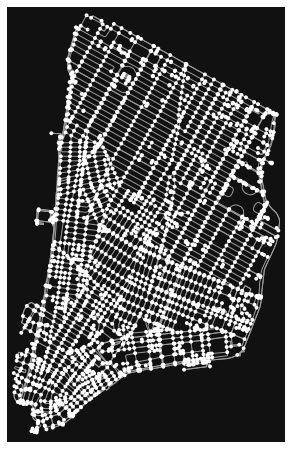

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
G = ox.io.load_graphml('../../data/mnh_below_34th.graphml')
ox.plot_graph(G)

Now we filter out all of the stations that aren't in our graph:

In [9]:
# Now we filter out all of the stations that aren't in our graph

# This is the distance from a trip start or endpoint to its nearest node beyond which we assume
# that the crash occurred outside of our graph and isn't really matched to that node.
THRESHOLD_DIST_M = 100
nearest_nodes = pd.DataFrame(columns=['NODE_ID', 'NODE_DIST_FROM_STATION_M', 'NODE_LATITUDE', 'NODE_LONGITUDE'])

for i, station in tqdm(all_stations.iterrows(), total=all_stations.shape[0]):
    nn_id, dist = ox.distance.nearest_nodes(G, station.station_longitude, station.station_latitude, return_dist=True)
    if dist > THRESHOLD_DIST_M:
        continue
    nn = G.nodes[nn_id]
    nearest_nodes.loc[i] = {
        'NODE_ID': nn_id,
        'NODE_DIST_FROM_STATION_M': dist,
        'NODE_LATITUDE': nn['y'],
        'NODE_LONGITUDE': nn['x'],
    }

stations_with_nodes = pd.concat((all_stations, nearest_nodes), join='inner', axis=1)

stations_with_nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 973/973 [00:12<00:00, 74.86it/s]


,station_latitude,station_longitude,NODE_ID,NODE_DIST_FROM_STATION_M,NODE_LATITUDE,NODE_LONGITUDE
79.0,40.719116,-74.006667,4616536355,20.166237,40.719069,-74.006435
82.0,40.711174,-74.000165,42444277,27.776007,40.711045,-74.000448
116.0,40.741776,-74.001497,4205565517,22.985989,40.741722,-74.001234
127.0,40.731724,-74.006744,6210448862,5.996575,40.731679,-74.006705
128.0,40.727103,-74.002971,42439335,28.031673,40.726878,-74.003122
...,...,...,...,...,...,...
3783.0,40.708380,-74.004950,673008453,15.153653,40.708406,-74.004774
3788.0,40.732690,-73.989740,42446528,25.271519,40.732756,-73.990027
3799.0,40.749640,-73.988050,4886228960,13.301574,40.749568,-73.987924
3812.0,40.734814,-73.992085,42436935,34.781083,40.734529,-73.992255


Now that we have this, we can go through every trip and quickly remove it if either its start or end are not in the index of our station list:

In [10]:
trip_df_in_area = trip_df[trip_df['end station id'].isin(stations_with_nodes.index) & trip_df['start station id'].isin(stations_with_nodes.index)]

trip_df_in_area

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,0,527,2019-10-01 00:00:05.6180,2019-10-01 00:08:52.9430,3746.0,6 Ave & Broome St,40.724308,-74.004730,223.0,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1
2,2,759,2019-10-01 00:00:19.8240,2019-10-01 00:12:59.7070,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,174.0,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1
4,4,761,2019-10-01 00:00:26.3800,2019-10-01 00:13:08.3130,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,174.0,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1
5,5,750,2019-10-01 00:00:37.9060,2019-10-01 00:13:08.4130,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,174.0,E 25 St & 1 Ave,40.738177,-73.977387,21757,Subscriber,1995,1
9,9,1301,2019-10-01 00:02:06.3010,2019-10-01 00:23:47.9460,3687.0,E 33 St & 1 Ave,40.743227,-73.974498,259.0,South St & Whitehall St,40.701221,-74.012342,41376,Subscriber,1963,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20551689,1478700,265,2019-11-30 23:58:46.8240,2019-12-01 00:03:12.1420,116.0,W 17 St & 8 Ave,40.741776,-74.001497,462.0,W 22 St & 10 Ave,40.746920,-74.004519,39333,Subscriber,1995,1
20551690,1478701,192,2019-11-30 23:58:49.3000,2019-12-01 00:02:01.5750,503.0,E 20 St & Park Ave,40.738274,-73.987520,297.0,E 15 St & 3 Ave,40.734232,-73.986923,15543,Subscriber,1966,2
20551692,1478703,534,2019-11-30 23:59:07.8070,2019-12-01 00:08:01.9840,251.0,Mott St & Prince St,40.723180,-73.994800,302.0,Avenue D & E 3 St,40.720828,-73.977932,33020,Subscriber,1996,2
20551694,1478705,668,2019-11-30 23:59:26.4970,2019-12-01 00:10:35.2200,408.0,Market St & Cherry St,40.710762,-73.994004,341.0,Stanton St & Mangin St,40.717821,-73.976289,15990,Subscriber,1998,1


Now we want to get the list of nodes involved in each trip and create a new row for each node involved in the trip:

In [12]:
trip = trip_df_in_area.loc[20551689]
stations_with_nodes.loc[trip['start station id']].NODE_ID

4205565517

In [13]:
trips_with_nodes = pd.DataFrame()
trips_with_no_paths = []

for i, trip in tqdm(trip_df_in_area.iterrows(), total=trip_df_in_area.shape[0]):
    start_node_id = stations_with_nodes.loc[trip['start station id']].NODE_ID
    end_node_id = stations_with_nodes.loc[trip['end station id']].NODE_ID

    try:
        route = ox.shortest_path(G, start_node_id, end_node_id)
    except NetworkXNoPath:
        trips_with_no_paths.append(i)
        continue

    route_df = pd.DataFrame(
        {
            'TRIP_ID': i,
            'NODE_ID': node_id,
            'NODE_LATITUDE': G.nodes[node_id]['y'],
            'NODE_LONGITUDE': G.nodes[node_id]['x'],
        }
        for node_id in route
    )
    
    trips_with_nodes = pd.concat((trips_with_nodes, route_df))
    
trips_with_nodes

  0%|▍                                                                                                                                 | 29049/7959557 [05:29<24:59:36, 88.14it/s]


KeyboardInterrupt: 

In [38]:
import dask.dataframe as dd

# df = dd.from_pandas(trip_df_in_area)
df = trip_df_in_area
trips_with_no_paths = []

def associate_nodes(trip):
    start_node_id = stations_with_nodes.loc[trip['start station id']].NODE_ID
    end_node_id = stations_with_nodes.loc[trip['end station id']].NODE_ID

    try:
        route = ox.shortest_path(G, start_node_id, end_node_id)
    except NetworkXNoPath:
        trips_with_no_paths.append(trip.name)
        return

    return pd.DataFrame(
        {
            'TRIP_ID': trip.name,
            'NODE_ID': node_id,
            'NODE_LATITUDE': G.nodes[node_id]['y'],
            'NODE_LONGITUDE': G.nodes[node_id]['x'],
        }
        for node_id in route
    )
    
trips_with_nodes = pd.concat(df.apply(associate_nodes, axis=1).values)

In [39]:
trips_with_nodes

,TRIP_ID,NODE_ID,NODE_LATITUDE,NODE_LONGITUDE
0,13014325,4461990857,40.750311,-73.991121
1,13014325,42439440,40.749706,-73.991563
2,13014325,8614943065,40.748955,-73.989760
3,13014325,42430295,40.748516,-73.988700
4,13014325,6223969260,40.748302,-73.988188
...,...,...,...,...
60,5190908,42433834,40.702712,-74.012229
61,5190908,42426747,40.702441,-74.012837
62,5190908,279151954,40.702407,-74.013783
63,5190908,4379778651,40.702234,-74.013804


So now that we have a node for each trip, what we want to do is join that dataframe against the trip dataframe using the trip ID column against the index to get the trip info for each row.

In [ ]:
all_nodes_with_trip_info = pd.merge(trips_with_nodes, trip_df_in_area, left_on='TRIP_ID', right_index=True)

In [ ]:
all_nodes_with_trip_info = all_nodes_with_trip_info.drop(columns=['index'])

In [ ]:
all_nodes_with_trip_info.to_csv('../../data/trip_data_normalized_2019-01-01_2019-12-31.csv')